# Task 1: Feed-forward neural networks


---

Tutorial: "Machine Learning in Solid Mechanics @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Assistants: Dominik K. Klein, Jasper O. Schommartz

---





*Run the following cell to clone the GitHub repository in your current Google Colab environment and install the local package. For the changes to take effect you might need to restart your Colabl session first ("Runtime / Restart session" in the header menu).*

In [1]:
!git clone --depth 1 https://github.com/CPShub/TutorialMLinSolidMechanics.git
!cd TutorialMLinSolidMechanics/ffnn_introduction && pip install -e .

Cloning into 'TutorialMLinSolidMechanics'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 144 (delta 4), reused 135 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 1.58 MiB | 4.73 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Obtaining file:///content/TutorialMLinSolidMechanics/ffnn_introduction
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 79.5 MB/s eta 0:00:00
   ━━━━

*Run the following cell to import all modules and python files to this notebook. If you made changes in the python files, run the following cell again to update the python files in this notebook. You might need to restart your Colab session first ("Runtime / Restart session" in the header menu).*

In [1]:
import datetime
import importlib

import jax
import jax.random as jrandom
import klax
from matplotlib import pyplot as plt
import time

import tmlsm.losses as tl
import tmlsm.data as td
import tmlsm.models as tm

importlib.reload(tm)
importlib.reload(tl)
importlib.reload(td)

now = datetime.datetime.now

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.2, so it will not be used.
  warnings.warn(


*If you want to clone the repository again, you have to delete it from your Google Colab files first. For this, you can run the following cell.*

In [2]:
%rm -rf TutorialMLinSolidMechanics

### Load data and model

In [3]:
# Create random key for reproducible weight initialization, and
# batch splits. The call to `time.time_ns()` may be replaced with
# a constant seed if exactly reproductible results ought to be
# produced.
key = jrandom.PRNGKey(time.time_ns())
keys = jrandom.split(key, 2)

# Build model instance
model = tm.build(key=keys[0])

# Load data
x, y, x_cal, y_cal = td.bathtub()

print(model)

Model(
  layers=(
    Linear(
      weight=f32[1,16],
      bias=f32[16],
      in_features='scalar',
      out_features=16,
      use_bias=True
    ),
    Linear(
      weight=f32[16,16],
      bias=f32[16],
      in_features=16,
      out_features=16,
      use_bias=True
    ),
    Linear(
      weight=f32[16,1],
      bias=f32[1],
      in_features=16,
      out_features='scalar',
      use_bias=True
    )
  ),
  activations=(
    <PjitFunction of <function softplus at 0x7cd37112ed40>>,
    <PjitFunction of <function softplus at 0x7cd37112ed40>>,
    <function Model.__init__.<locals>.<lambda>>
  )
)


2025-10-15 23:16:05.241933
Step: 0, Loss: 1.421e+01
Step: 1, Loss: 1.355e+01
Step: 2, Loss: 1.290e+01
Step: 3, Loss: 1.226e+01
Step: 4, Loss: 1.165e+01
Step: 5, Loss: 1.106e+01
Step: 6, Loss: 1.048e+01
Step: 7, Loss: 9.924e+00
Step: 8, Loss: 9.385e+00
Step: 9, Loss: 8.863e+00
Step: 10, Loss: 8.359e+00
Step: 11, Loss: 7.872e+00
Step: 12, Loss: 7.405e+00
Step: 13, Loss: 6.958e+00
Step: 14, Loss: 6.527e+00
Step: 15, Loss: 6.117e+00
Step: 16, Loss: 5.729e+00
Step: 17, Loss: 5.357e+00
Step: 18, Loss: 5.003e+00
Step: 19, Loss: 4.667e+00
Step: 20, Loss: 4.346e+00
Step: 21, Loss: 4.042e+00
Step: 22, Loss: 3.753e+00
Step: 23, Loss: 3.480e+00
Step: 24, Loss: 3.220e+00
Step: 25, Loss: 2.977e+00
Step: 26, Loss: 2.747e+00
Step: 27, Loss: 2.531e+00
Step: 28, Loss: 2.328e+00
Step: 29, Loss: 2.138e+00
Step: 30, Loss: 1.959e+00
Step: 31, Loss: 1.793e+00
Step: 32, Loss: 1.637e+00
Step: 33, Loss: 1.491e+00
Step: 34, Loss: 1.356e+00
Step: 35, Loss: 1.232e+00
Step: 36, Loss: 1.117e+00
Step: 37, Loss: 1.011

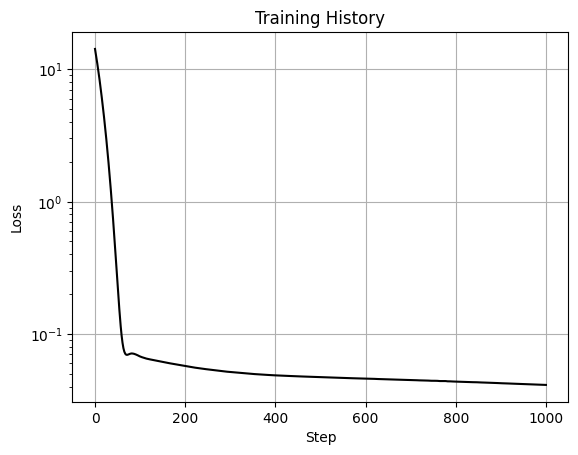

In [4]:
# Calibrate model
t1 = now()
print(t1)

model, history = klax.fit(
    model,
    (x_cal, y_cal),
    batch_size=32,
    steps=1_000,
    loss_fn=tl.MSE(),
    history=klax.HistoryCallback(log_every=1),
    key=keys[1],
)

t2 = now()
print("it took", t2 - t1, "(sec) to calibrate the model")

history.plot()

### Model evaluation

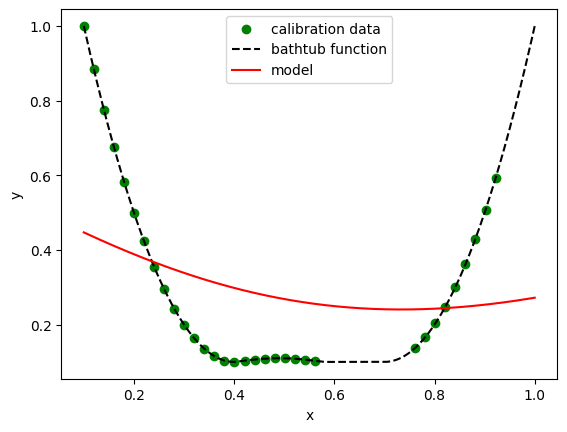

In [5]:
# First the model need to be finalized to unwrap and apply all
# wrappers and constraints (if present).
model_ = klax.finalize(model)

plt.figure(2)
plt.scatter(x_cal[::10], y_cal[::10], c="green", label="calibration data")
plt.plot(x, y, c="black", linestyle="--", label="bathtub function")
plt.plot(x, jax.vmap(model_)(x), label="model", color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [1]:
!git clone https://github.com/nowhereman101/TutorialMLinSolidMechanics.git


Cloning into 'TutorialMLinSolidMechanics'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 317 (delta 20), reused 31 (delta 11), pack-reused 258 (from 1)
Receiving objects: 100% (317/317), 11.93 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [2]:
!ls


sample_data  TutorialMLinSolidMechanics


In [3]:
!pwd


/content


In [4]:
%cd TutorialMLinSolidMechanics


/content/TutorialMLinSolidMechanics


In [5]:
%cd nowhereman101

[Errno 2] No such file or directory: 'nowhereman101'
/content/TutorialMLinSolidMechanics


In [6]:
!ls


 ffnn_introduction   README.md	   viscoelasticity
 hyperelasticity    'Task 1.pdf'


In [7]:
!python main.py


python3: can't open file '/content/TutorialMLinSolidMechanics/main.py': [Errno 2] No such file or directory
